# Forest cover prediction using deep learning
Data from the US Forest Service (USFS) Region 2 Resource Information System.
This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado.

It seems to come from Kaggle: https://www.kaggle.com/competitions/cover-type-prediction-of-forests/data

### Import modules
I like to keep my imports together

In [174]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

from scikeras.wrappers import KerasClassifier

import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score

from scipy.stats import randint

from matplotlib import pyplot as plt
from collections import Counter

import ipywidgets as widgets


In [74]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import and explore dataset

In [75]:
dataset = pd.read_csv("cover_data.csv")

In [76]:
#Print info on the dataset
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

Nice, all data is numeric.  

We want to predict the column "class"  
Let us see some more info

In [5]:
#print the class distribution
print(Counter(dataset["class"]))

Counter({2: 283301, 1: 211840, 3: 35754, 7: 20510, 6: 17367, 5: 9493, 4: 2747})


Note, there are much more entries of 1 and 2 compared to the rest. This is important, as will become clear.

Forest Cover Type Classes (From Kaggle):  
1 -- Spruce/Fir  
2 -- Lodgepole Pine  
3 -- Ponderosa Pine  
4 -- Cottonwood/Willow  
5 -- Aspen  
6 -- Douglas-fir  
7 -- Krummholz

In [6]:
# Lets make a labels dict
labels = {1 : "Spruce/Fir",
          2 : "Lodgepole Pine",
          3 : "Ponderosa Pine",
          4 : "Cottonwood/Willow",
          5 : "Aspen",
          6 : "Douglas-fir",
          7 : "Krummholz"}

## Prepare data

First, select features and target data

In [7]:
x = dataset.iloc[:, :-1] # Features is everything but the last column in first approx
y = dataset.iloc[:, -1] # Target is the last column

Then, perform train test split

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 12)

Analyze data for outliers etc

In [12]:
@widgets.interact
def scatter_plot(feature=list(x.columns),
                 n_bins = widgets.IntSlider(min = 10, max = 200, step =5, value = 20)
                ):
                
    fig, ax1 = plt.subplots()
    
    color = 'tab:blue'
    ax1.hist(x_train[feature], bins=n_bins)
    

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

interactive(children=(Dropdown(description='feature', options=('Elevation', 'Aspect', 'Slope', 'Horizontal_Dis…

Scale all input data using a ColumnTransformer

In [25]:
# Create the Transformer
numerical_data = x.select_dtypes(include = ["float64", "int64"])
numerical_columns = numerical_data.columns[0:10] # I do not want to rescale the categorical values
ct = ColumnTransformer([("Only numerical columns", StandardScaler(), numerical_columns)], remainder = "passthrough")

# Scale data
x_train_transformed = ct.fit_transform(x_train)
x_test_transformed = ct.transform(x_test)

Check data again

In [26]:
@widgets.interact
def scatter_plot(feature=list(x.columns),
                 n_bins = widgets.IntSlider(min = 10, max = 200, step =5, value = 20)
                ):
                
    fig, ax1 = plt.subplots()
    
    color = 'tab:blue'
    ax1.hist(x_train_transformed[:, list(x.columns).index(feature)], bins=n_bins)
    

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

interactive(children=(Dropdown(description='feature', options=('Elevation', 'Aspect', 'Slope', 'Horizontal_Dis…

For Y we will use Crossentropy from Keras

In [28]:
#encode the labels into integers
le = LabelEncoder()
#convert the integer encoded labels into binary vectors
y_train=le.fit_transform(y_train.astype(str))
y_test=le.transform(y_test.astype(str))
#convert the integer encoded labels into binary vectors
y_train = tf.keras.utils.to_categorical(y_train, dtype = 'int64')
y_test = tf.keras.utils.to_categorical(y_test, dtype = 'int64')

## Model Building

### Model 1: simple and naive

Step 1: Define the model

In [27]:
# Building a simple sequential model
simple_model = Sequential() 
#add the input layer with a shape based on the Features
simple_model.add(layers.InputLayer(input_shape=(x_train.shape[1],)))
#add 2 hidden layers
simple_model.add(layers.Dense(28, activation='relu'))
simple_model.add(layers.Dense(14, activation='relu'))
#add an output layer
simple_model.add(layers.Dense(7, activation='softmax'))
# define optimizer and learning rate
learning_rate = 0.001
opt = opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
#compile the model, sparse categocical cross entropy, adam optimizer, simple accuracy metrics
simple_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print(simple_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 28)                1540      
                                                                 
 dense_1 (Dense)             (None, 14)                406       
                                                                 
 dense_2 (Dense)             (None, 7)                 105       
                                                                 
Total params: 2,051
Trainable params: 2,051
Non-trainable params: 0
_________________________________________________________________
None


2023-03-08 16:14:20.631010: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-08 16:14:20.631054: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-08 16:14:20.631085: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (2bdea2321840): /proc/driver/nvidia/version does not exist
2023-03-08 16:14:20.631401: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Step 2: initial fit

In [36]:
history = simple_model.fit(x_train_transformed, y_train, epochs=5, batch_size= 100, verbose=1, validation_split = 0.2)

Epoch 1/5
3487/3487 [==============================] - 14s 4ms/step - loss: 0.6559 - accuracy: 0.7223 - val_loss: 0.6170 - val_accuracy: 0.7343
Epoch 2/5
3487/3487 [==============================] - 13s 4ms/step - loss: 0.5972 - accuracy: 0.7417 - val_loss: 0.5864 - val_accuracy: 0.7448
Epoch 3/5
3487/3487 [==============================] - 13s 4ms/step - loss: 0.5707 - accuracy: 0.7529 - val_loss: 0.5628 - val_accuracy: 0.7563
Epoch 4/5
3487/3487 [==============================] - 13s 4ms/step - loss: 0.5536 - accuracy: 0.7608 - val_loss: 0.5511 - val_accuracy: 0.7611
Epoch 5/5
3487/3487 [==============================] - 13s 4ms/step - loss: 0.5428 - accuracy: 0.7651 - val_loss: 0.5457 - val_accuracy: 0.7638


Step 3: plot some results

Final training accuracy: 0.7650535106658936
Final validation accuracy: 0.7637690305709839


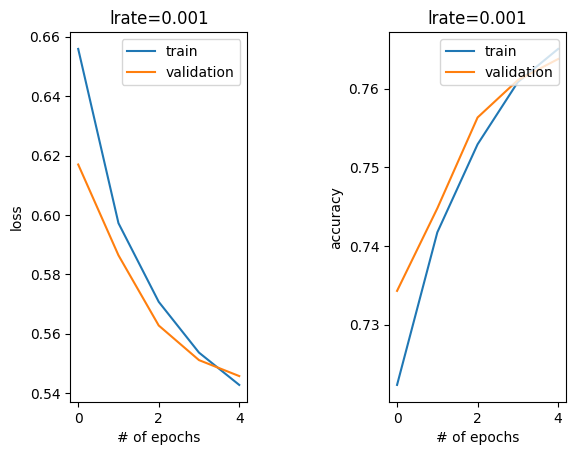

In [37]:
def plot(history):
    # plot learning curves
    fig, axs = plt.subplots(1, 2, gridspec_kw={'hspace': 1, 'wspace': 0.8})
    (ax1, ax2) = axs
    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='validation')
    ax1.set_title('lrate=' + str(learning_rate))
    ax1.legend(loc="upper right")
    ax1.set_xlabel("# of epochs")
    ax1.set_ylabel("loss")

    ax2.plot(history.history['accuracy'], label='train')
    ax2.plot(history.history['val_accuracy'], label='validation')
    ax2.set_title('lrate=' + str(learning_rate))
    ax2.legend(loc="upper right")
    ax2.set_xlabel("# of epochs")
    ax2.set_ylabel("accuracy")
    print("Final training accuracy:", history.history['accuracy'][-1])
    print("Final validation accuracy:", history.history['val_accuracy'][-1])
    plt.show()

plot(history)

Step 4: Save model for later comparison

In [13]:
simple_model_file = "../models/simple_model"
simple_model.save(simple_model_file)

INFO:tensorflow:Assets written to: ../models/simple_model/assets


INFO:tensorflow:Assets written to: ../models/simple_model/assets


In [12]:
simple_model_file = "../models/simple_model"
simple_model = tf.keras.models.load_model(simple_model_file)

### Evaluating simple model  
The accuracy looks good, right?

4540/4540 [==============================] - 8s 2ms/step
              precision    recall  f1-score   support

           0       0.80      0.68      0.74     53065
           1       0.76      0.87      0.81     70651
           2       0.70      0.86      0.77      8991
           3       0.69      0.52      0.59       710
           4       0.63      0.24      0.34      2348
           5       0.59      0.27      0.37      4329
           6       0.80      0.78      0.79      5159

    accuracy                           0.77    145253
   macro avg       0.71      0.60      0.63    145253
weighted avg       0.77      0.77      0.76    145253



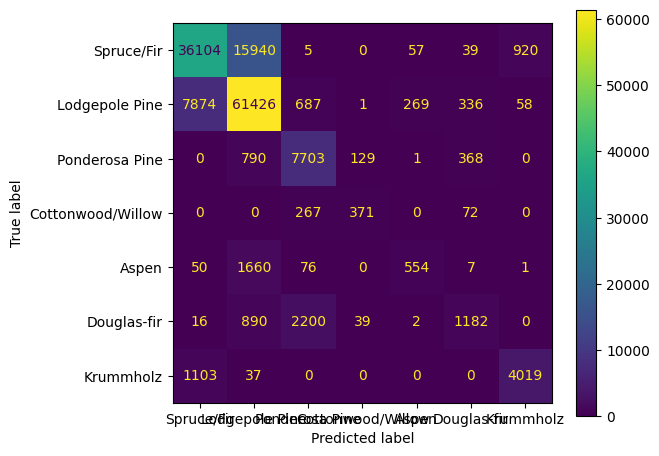

In [41]:
# Calculate some simple metrics and the confusion Matrix
y_pred = simple_model.predict(x_test_transformed)
y_pred = np.argmax(y_pred, axis = 1)
print(classification_report(np.argmax(y_test, axis = 1), y_pred))
cm = confusion_matrix(np.argmax(y_test, axis = 1), y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = list(labels.values()))
disp.plot()
plt.tight_layout()
plt.show()

So what we see here is that accuracy is a flawed metric for such an imbalanced dataset.  
The machine learning model clearly favours putting the data in the classes with many samples, as this is "right in most of the cases."
This kind of bias will not get much better with a bit of optimization. Better to:
- Find a way to make the data a bit more balanced by augmenting underrepresented classes/dropping some of the larger ones
- Optimize the metrics with which we score/put some additional weight on the small classes

### Model 2: Do something about the imbalance
We start by introducing some weights. I can't collect new data, and I'm hesitant to invent some just for now.

The basis of the model might still be salvable

In [42]:
# Building a simple sequential model
simple_model2 = Sequential() 
#add the input layer with a shape based on the Features
simple_model2.add(layers.InputLayer(input_shape=(x_train.shape[1],)))
#add 2 hidden layers
simple_model2.add(layers.Dense(28, activation='relu'))
simple_model2.add(layers.Dense(14, activation='relu'))
#add an output layer
simple_model2.add(layers.Dense(7, activation='softmax'))
# define optimizer and learning rate
learning_rate2 = 0.002
opt2 = tf.keras.optimizers.Adam(learning_rate = learning_rate2)
#compile the model, sparse categocical cross entropy, adam optimizer, simple accuracy metrics
simple_model2.compile(loss='categorical_crossentropy', optimizer=opt2, metrics = ["Precision", "Recall"])
print(simple_model2.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 28)                1540      
                                                                 
 dense_7 (Dense)             (None, 14)                406       
                                                                 
 dense_8 (Dense)             (None, 7)                 105       
                                                                 
Total params: 2,051
Trainable params: 2,051
Non-trainable params: 0
_________________________________________________________________
None


Calculate relative weights of classes:

In [47]:
train_weights = 1/(np.sum(y_train, axis = 0)/np.sum(y_train))
class_weights = {}
for i in range(y_train.shape[1]):
    class_weights[i] = train_weights[i]

In [49]:
print(np.max(train_weights), np.min(train_weights))

213.92194403534612 2.049184105337409


We are also going to make our batch_size larger, as we want an example of every class in every batch.   
Therefore batch size is going to be larger than max weight. I will use a factor of about 2 here.

In [50]:
history2 = simple_model2.fit(x_train_transformed, y_train, 
                             epochs=50, batch_size= 250, 
                             verbose=1, validation_split = 0.2,
                            class_weight=class_weights)

Epoch 1/50
1395/1395 [==============================] - 7s 5ms/step - loss: 5.3324 - precision: 0.6384 - recall: 0.4648 - val_loss: 0.7996 - val_precision: 0.6686 - val_recall: 0.6013
Epoch 2/50
1395/1395 [==============================] - 6s 5ms/step - loss: 4.1230 - precision: 0.6618 - recall: 0.6037 - val_loss: 0.8135 - val_precision: 0.6596 - val_recall: 0.6121
Epoch 3/50
1395/1395 [==============================] - 6s 5ms/step - loss: 3.8911 - precision: 0.6760 - recall: 0.6299 - val_loss: 0.7709 - val_precision: 0.6736 - val_recall: 0.6310
Epoch 4/50
1395/1395 [==============================] - 7s 5ms/step - loss: 3.7331 - precision: 0.6834 - recall: 0.6421 - val_loss: 0.7626 - val_precision: 0.6847 - val_recall: 0.6456
Epoch 5/50
1395/1395 [==============================] - 7s 5ms/step - loss: 3.6259 - precision: 0.6891 - recall: 0.6503 - val_loss: 0.7478 - val_precision: 0.6816 - val_recall: 0.6436
Epoch 6/50
1395/1395 [==============================] - 7s 5ms/step - loss: 3.54

Check how out new model behaves

Final training Precision: 0.7418987154960632
Final validation Precision: 0.7300513982772827
Final training recall: 0.7190675735473633
Final validation recall: 0.7073503732681274


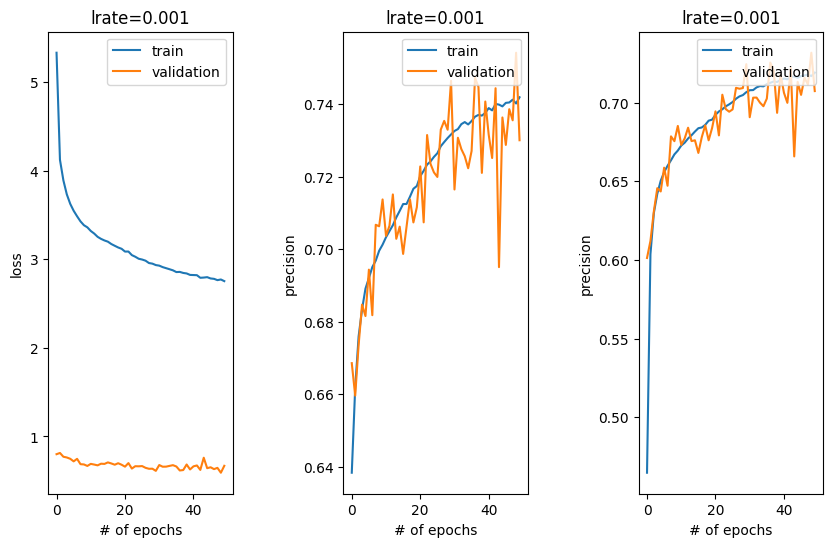

In [66]:
def plot2(history):
    # plot learning curves
    fig, axs = plt.subplots(1, 3, gridspec_kw={'hspace': 1, 'wspace': .6}, figsize = (10, 6))
    (ax1, ax2, ax3) = axs
    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='validation')
    ax1.set_title('lrate=' + str(learning_rate))
    ax1.legend(loc="upper right")
    ax1.set_xlabel("# of epochs")
    ax1.set_ylabel("loss")

    ax2.plot(history.history['precision'], label='train')
    ax2.plot(history.history['val_precision'], label='validation')
    ax2.set_title('lrate=' + str(learning_rate))
    ax2.legend(loc="upper right")
    ax2.set_xlabel("# of epochs")
    ax2.set_ylabel("precision")
    print("Final training Precision:", history.history['precision'][-1])
    print("Final validation Precision:", history.history['val_precision'][-1])
    
    ax3.plot(history.history['recall'], label='train')
    ax3.plot(history.history['val_recall'], label='validation')
    ax3.set_title('lrate=' + str(learning_rate))
    ax3.legend(loc="upper right")
    ax3.set_xlabel("# of epochs")
    ax3.set_ylabel("precision")
    print("Final training recall:", history.history['recall'][-1])
    print("Final validation recall:", history.history['val_recall'][-1])
    plt.show()

plot2(history2)

And the new metrics and confusion matix

4540/4540 [==============================] - 8s 2ms/step
              precision    recall  f1-score   support

           0       0.79      0.70      0.74     53065
           1       0.82      0.70      0.75     70651
           2       0.78      0.79      0.78      8991
           3       0.60      0.93      0.72       710
           4       0.20      0.97      0.33      2348
           5       0.51      0.84      0.64      4329
           6       0.60      0.97      0.74      5159

    accuracy                           0.73    145253
   macro avg       0.61      0.84      0.67    145253
weighted avg       0.78      0.73      0.74    145253



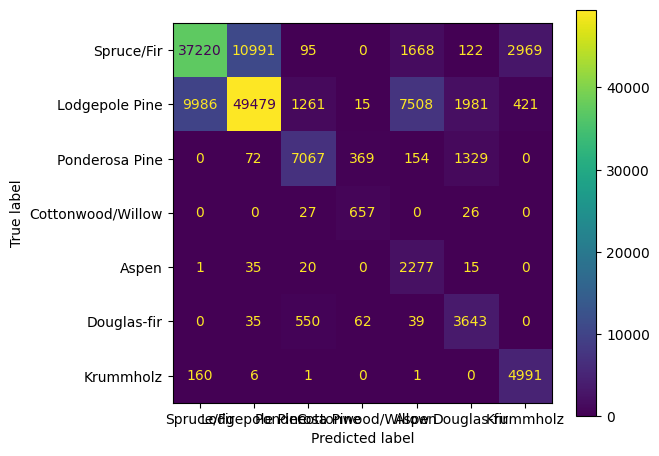

In [77]:
# Calculate some simple metrics and the confusion Matrix
y_pred2 = simple_model2.predict(x_test_transformed)
y_pred2 = np.argmax(y_pred2, axis = 1)
print(classification_report(np.argmax(y_test, axis = 1), y_pred2))
cm2 = confusion_matrix(np.argmax(y_test, axis = 1), y_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels = list(labels.values()))
disp.plot()
plt.tight_layout()
plt.show()

Nice, we are on the right track and get more elements on our diagonal.

In [115]:
simple_model2.layers[2].get_weights()

[array([[ 5.4922271e-01,  5.0485577e-02,  2.6245305e-01, -2.9906923e-01,
          7.3236883e-01,  2.2589697e-01, -2.0951183e+00],
        [ 3.9650032e-01,  4.1236082e-01, -1.3162180e+00, -2.5350683e+00,
          2.6638165e-01,  8.9380926e-01, -8.5776913e-01],
        [-1.6528701e+00, -5.4968709e-01,  4.9799764e-01,  5.0369328e-01,
         -3.4391347e-01,  2.7584064e-01,  3.8255855e-01],
        [-1.6765499e-02, -7.1295941e-01,  9.9505559e-02,  1.5587635e+00,
          1.9683074e-02, -9.0852022e-01, -3.3918512e-01],
        [ 6.1183500e-01,  2.9838341e-01,  5.1543725e-01, -2.9442544e+00,
          4.0696147e-01,  5.1735616e-01,  2.8793970e-01],
        [ 8.6574942e-01,  1.0009670e+00,  1.1683779e+00, -6.9303050e+00,
         -2.5885675e+00, -6.6251159e+00,  6.9288969e-02],
        [ 5.5810511e-01,  6.4369541e-01, -3.3229699e+00, -1.7179238e+00,
          6.0949689e-01, -8.1314951e-02,  4.6740291e-01],
        [-4.6126049e-02, -6.5081912e-01, -2.3413656e-02, -6.3353527e-01,
          

Save/load, uncomment as needed

In [86]:
simple_model2_file = "../models/simple_weighted_model"
#simple_model2.save(simple_model2_file)
simple_model2 = tf.keras.models.load_model(simple_model2_file)

## Intermediate conclusions:
1) Classes are really uneven
2) After 50 epochs the simple model is still learning
3) Weighing the classes helps

## Tuning hyperparameters

There are many things to optimize
- So far the models have been quite simple (2 hidden layers, 54 -> 28 -> 14 -> 7 in size). We can add complexity, size, and regulation.
- Learning rate
- Epochs
- Batch size
- Early Stopping
- ...
I will try to optimize some parameters by hand, and others using a randomized search.

### Models of different complexity
Not all tested architectures will be included in this notebook

In [128]:
# Building a more complex sequential model
complex_model = Sequential() 
#add the input layer with a shape based on the Features
complex_model.add(layers.InputLayer(input_shape=(x_train.shape[1],)))
#add hidden layers with dropouts
complex_model.add(layers.Dense(64, activation='relu'))
complex_model.add(layers.Dense(64, activation='relu'))
complex_model.add(layers.Dense(32, activation='relu'))
complex_model.add(layers.Dense(32, activation='relu'))
complex_model.add(layers.Dense(32, activation='relu'))
complex_model.add(layers.Dense(32, activation='relu'))
complex_model.add(layers.Dense(16, activation='relu'))
#add an output layer
complex_model.add(layers.Dense(7, activation='softmax'))
# define optimizer and learning rate
learning_rate = 0.002
opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
#compile the model, sparse categocical cross entropy, adam optimizer, simple accuracy metrics
complex_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ["Precision", "Recall"])
print(complex_model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 64)                3520      
                                                                 
 dropout_27 (Dropout)        (None, 64)                0         
                                                                 
 dense_53 (Dense)            (None, 64)                4160      
                                                                 
 dropout_28 (Dropout)        (None, 64)                0         
                                                                 
 dense_54 (Dense)            (None, 32)                2080      
                                                                 
 dropout_29 (Dropout)        (None, 32)                0         
                                                                 
 dense_55 (Dense)            (None, 32)              

In [129]:
complex_history = complex_model.fit(x_train_transformed, y_train, 
                             epochs=50, batch_size= 250, 
                             verbose=0, validation_split = 0.2,
                            class_weight=class_weights)

Final training Precision: 0.86207515001297
Final validation Precision: 0.8347883820533752
Final training recall: 0.8552696704864502
Final validation recall: 0.8239741921424866


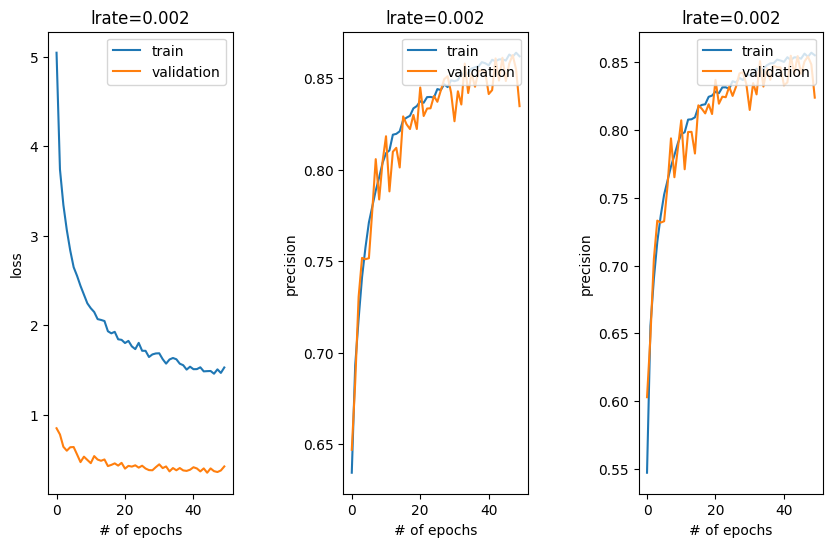

In [130]:
plot2(complex_history)

4540/4540 [==============================] - 9s 2ms/step
              precision    recall  f1-score   support

           0       0.83      0.85      0.84     53065
           1       0.91      0.79      0.85     70651
           2       0.81      0.89      0.85      8991
           3       0.60      0.94      0.73       710
           4       0.37      0.96      0.54      2348
           5       0.73      0.85      0.78      4329
           6       0.67      0.98      0.80      5159

    accuracy                           0.83    145253
   macro avg       0.70      0.89      0.77    145253
weighted avg       0.85      0.83      0.84    145253



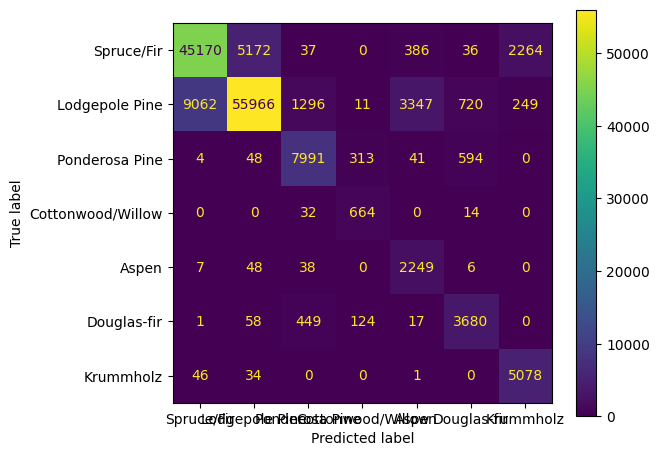

In [131]:
# Calculate some simple metrics and the confusion Matrix
y_pred_c = complex_model.predict(x_test_transformed)
y_pred_c = np.argmax(y_pred_c, axis = 1)
print(classification_report(np.argmax(y_test, axis = 1), y_pred_c))
cm_c = confusion_matrix(np.argmax(y_test, axis = 1), y_pred_c)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_c, display_labels = list(labels.values()))
disp.plot()
plt.tight_layout()
plt.show()

In [132]:
complex_model_file = "../models/complex_64_64_32_32_32_32_16"
complex_model.save(complex_model_file)
#complex_model = tf.keras.models.load_model(complex_model_file)

INFO:tensorflow:Assets written to: ../models/complex_64_64_32_32_32_32_16/assets


INFO:tensorflow:Assets written to: ../models/complex_64_64_32_32_32_32_16/assets


In [126]:
class_weights

{0: 2.7445063769485123,
 1: 2.049184105337409,
 2: 16.282143257482346,
 3: 213.92194403534612,
 4: 60.98796361091673,
 5: 33.422227335480905,
 6: 28.38635919484073}

### Use this model archetecture to optimize other hyperparameters

First we'll go for batch size and numbers of epoch

In [156]:
# Well need a model generator for this
def build_model():
    model = Sequential() 
    #add the input layer with a shape based on the Features
    model.add(layers.InputLayer(input_shape=(x_train_transformed.shape[1],)))
    #add hidden layers with dropouts
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    #add an output layer
    model.add(layers.Dense(7, activation='softmax'))
    # define optimizer and learning rate
    #compile the model, sparse categocical cross entropy, adam optimizer, simple accuracy metrics
    return model

Also, let us define the area that we search

In [175]:
# define the grid search parameters
batch_size = list(np.linspace(50, 1000, 51).astype(np.int32))
epochs = list(np.geomspace(10, 100, 10).astype(np.int32))
param_grid = dict(batch_size=batch_size, epochs=epochs)
param_grid["loss"] = ["categorical_crossentropy"]
param_grid["optimizer"] = ["adam"]
param_grid["optimizer__learning_rate"] = [0.002]

We'll do a test for 12 combinations of parameters for now

In [ ]:
model = KerasClassifier(model = build_model)

grid = RandomizedSearchCV(estimator = model, param_distributions=param_grid, 
                          n_iter = 12)

grid_result = grid.fit(x_train_transformed, y_train, verbose = 0)
print(grid_result)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [183]:
# Create and display Pandas DataFrame
df = pd.concat([pd.DataFrame(grid_result.cv_results_['params']), pd.DataFrame(grid_result.cv_results_['mean_test_score'], columns=['Accuracy'])], axis=1)
cv_table = df.sort_values("Accuracy", ascending = False)
display(cv_table)

,optimizer__learning_rate,optimizer,loss,epochs,batch_size,Accuracy
9,0.002,adam,categorical_crossentropy,100,639,0.919118
8,0.002,adam,categorical_crossentropy,100,620,0.915703
2,0.002,adam,categorical_crossentropy,100,145,0.914785
1,0.002,adam,categorical_crossentropy,59,259,0.912300
5,0.002,adam,categorical_crossentropy,77,677,0.911403
3,0.002,adam,categorical_crossentropy,35,69,0.907068
10,0.002,adam,categorical_crossentropy,35,335,0.901992
0,0.002,adam,categorical_crossentropy,21,69,0.899743
6,0.002,adam,categorical_crossentropy,27,354,0.898685
7,0.002,adam,categorical_crossentropy,16,544,0.882077


In [190]:
# save this output
cv_table.to_csv("../models/RandomizedSearchCV_results.csv")
grid.best_estimator_.model_.save("../models/RandomizedSearchCV_optimal_model")

INFO:tensorflow:Assets written to: ../models/RandomizedSearchCV_optimal_model/assets


INFO:tensorflow:Assets written to: ../models/RandomizedSearchCV_optimal_model/assets


228/228 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.94      0.89      0.91     53065
           1       0.91      0.96      0.93     70651
           2       0.89      0.93      0.91      8991
           3       0.89      0.75      0.82       710
           4       0.78      0.79      0.79      2348
           5       0.87      0.78      0.82      4329
           6       0.95      0.88      0.92      5159

    accuracy                           0.92    145253
   macro avg       0.89      0.85      0.87    145253
weighted avg       0.92      0.92      0.92    145253



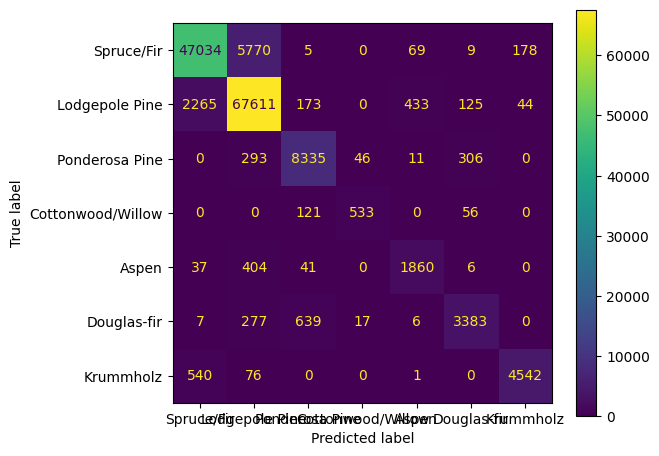

In [191]:
# Calculate some simple metrics and the confusion Matrix
y_pred_CV = grid.predict(x_test_transformed)
y_pred_CV = np.argmax(y_pred_CV, axis = 1)
print(classification_report(np.argmax(y_test, axis = 1), y_pred_CV))
cm_CV = confusion_matrix(np.argmax(y_test, axis = 1), y_pred_CV)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_CV, display_labels = list(labels.values()))
disp.plot()
plt.tight_layout()
plt.show()

Nice, we seem no still avoid overfitting, and get rather decent f1 scores for each class.

## Analysis
What we see here is that in this range of epochs, more is better.
For a low amount of epochs it seems that learning is better with a small batch size, with a crossover when increasing the amount of epochs.
As we have unbalanced classes, I think that large batch size and many epochs will gi9ve the best results.
However, if training resources are limited the optimal point for this balance might be different.

Further optimization can be performed by e.g.:
- Tuning the learning rate
- Adding dropout regulation
- Simply training more (checking for overfitting)
- We can even contemplate changing the optimizer itself

However, how much time (and CPU/GPU cycles!) should be devoted to this optimizing depends strongly on the goals of the model. Here the main goal is practice for machgine learning, and not finding the most perfect model. I think the goals for practice for now have been reached, and prefer learning now some new other things. Because one can always continue learning.